## Note
This notebook includes graphs for time series analysis, which are a simplified version of the whole approach. I did not employ any of the well-known time series models (ARIMA/F-Prohet, etc.). 
You will only benefit from the analysis; even the features generated here may be irrelevant (consider it as a baseline, which was mine).  
time series analysis is a broad field that we can never easily cover it in a kerenl

# Importings

In [1]:
import pandas as pd                                    
import numpy as np                                     
from lightgbm import LGBMRegressor                     
from sklearn.metrics import mean_squared_error         
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit   
from sklearn.preprocessing import LabelEncoder         
import seaborn as sns                     
import matplotlib.pyplot as plt    
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from path import Path #reading the path
path = Path('/Dataset')
train = pd.read_csv(path / 'Train.csv')
test = pd.read_csv(path / 'Test.csv')

test_id = test['ID_Zindi']
pd.options.display.max_columns = 200

# Exploratoray Data Analysis

In [2]:
train.describe()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
count,86584.000000,86584.000000,86584.000000,46798.000000,73709.000000,73709.000000,73709.000000,73709.000000,51111.000000,73709.000000,82051.000000
mean,45.421456,10.014272,2.585528,299.268841,-1.274999,0.200606,0.000045,0.000156,0.000105,16655.112392,24.535051
std,0.225409,1.056637,7.617394,10.927167,0.693003,0.259607,0.000012,0.000103,0.000092,3000.748790,17.108838
min,44.924694,8.736497,0.000000,253.200000,-5.196266,0.000000,0.000013,-0.000012,-0.000025,8614.349685,0.000000
25%,45.249544,9.195325,0.000000,290.920000,-1.749425,0.023900,0.000034,0.000100,0.000047,14432.114060,11.875000
50%,45.478996,9.611738,0.000000,300.760000,-1.349746,0.078478,0.000047,0.000122,0.000071,16711.190570,20.000000
75%,45.601232,10.683357,0.000000,307.940000,-0.878857,0.278451,0.000056,0.000173,0.000129,19252.648570,33.050000
max,45.889734,12.590682,135.396805,327.840000,2.143020,1.000000,0.000073,0.002047,0.001097,24449.007150,188.233333


In [3]:
for col in train.columns: 
    print(col)
    print (train[col].max(), '|',train[col].min())
    print('__________________')

ID_Zindi
ID_ZZZAQB | ID_00017O
__________________
Date
9/9/21 | 1/1/19
__________________
ID
X9999 | PD01
__________________
LAT
45.88973369 | 44.92469405
__________________
LON
12.59068235 | 8.736496578
__________________
Precipitation
135.3968048 | 0.0
__________________
LST
327.84 | 253.2
__________________
AAI
2.143020488 | -5.196266174
__________________
CloudFraction
1.000000044 | 0.0
__________________
NO2_strat
7.28e-05 | 1.34e-05
__________________
NO2_total
0.002047452 | -1.19e-05
__________________
NO2_trop
0.001097291 | -2.53e-05
__________________
TropopausePressure
24449.00715 | 8614.349685
__________________
GT_NO2
188.2333333 | 0.0
__________________


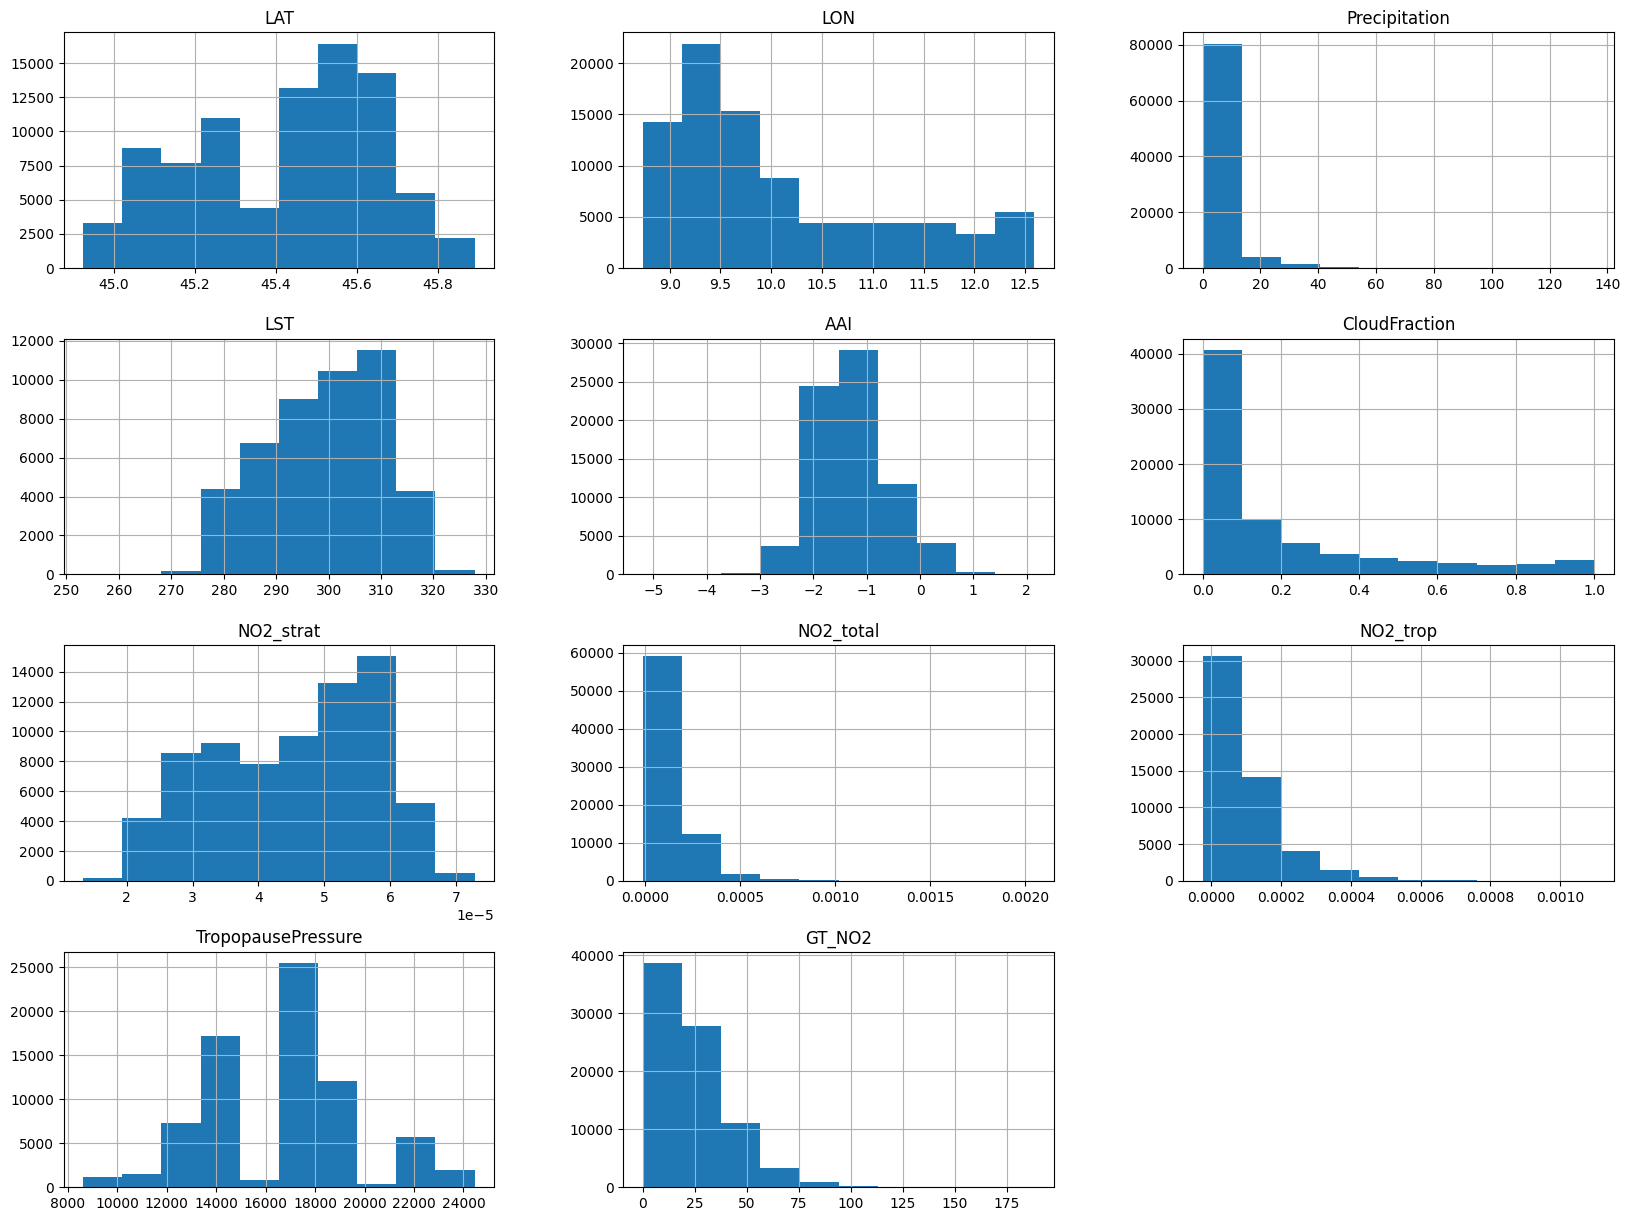

In [4]:
num_feats = list(train.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train[num_feats].hist(figsize=(20,15));

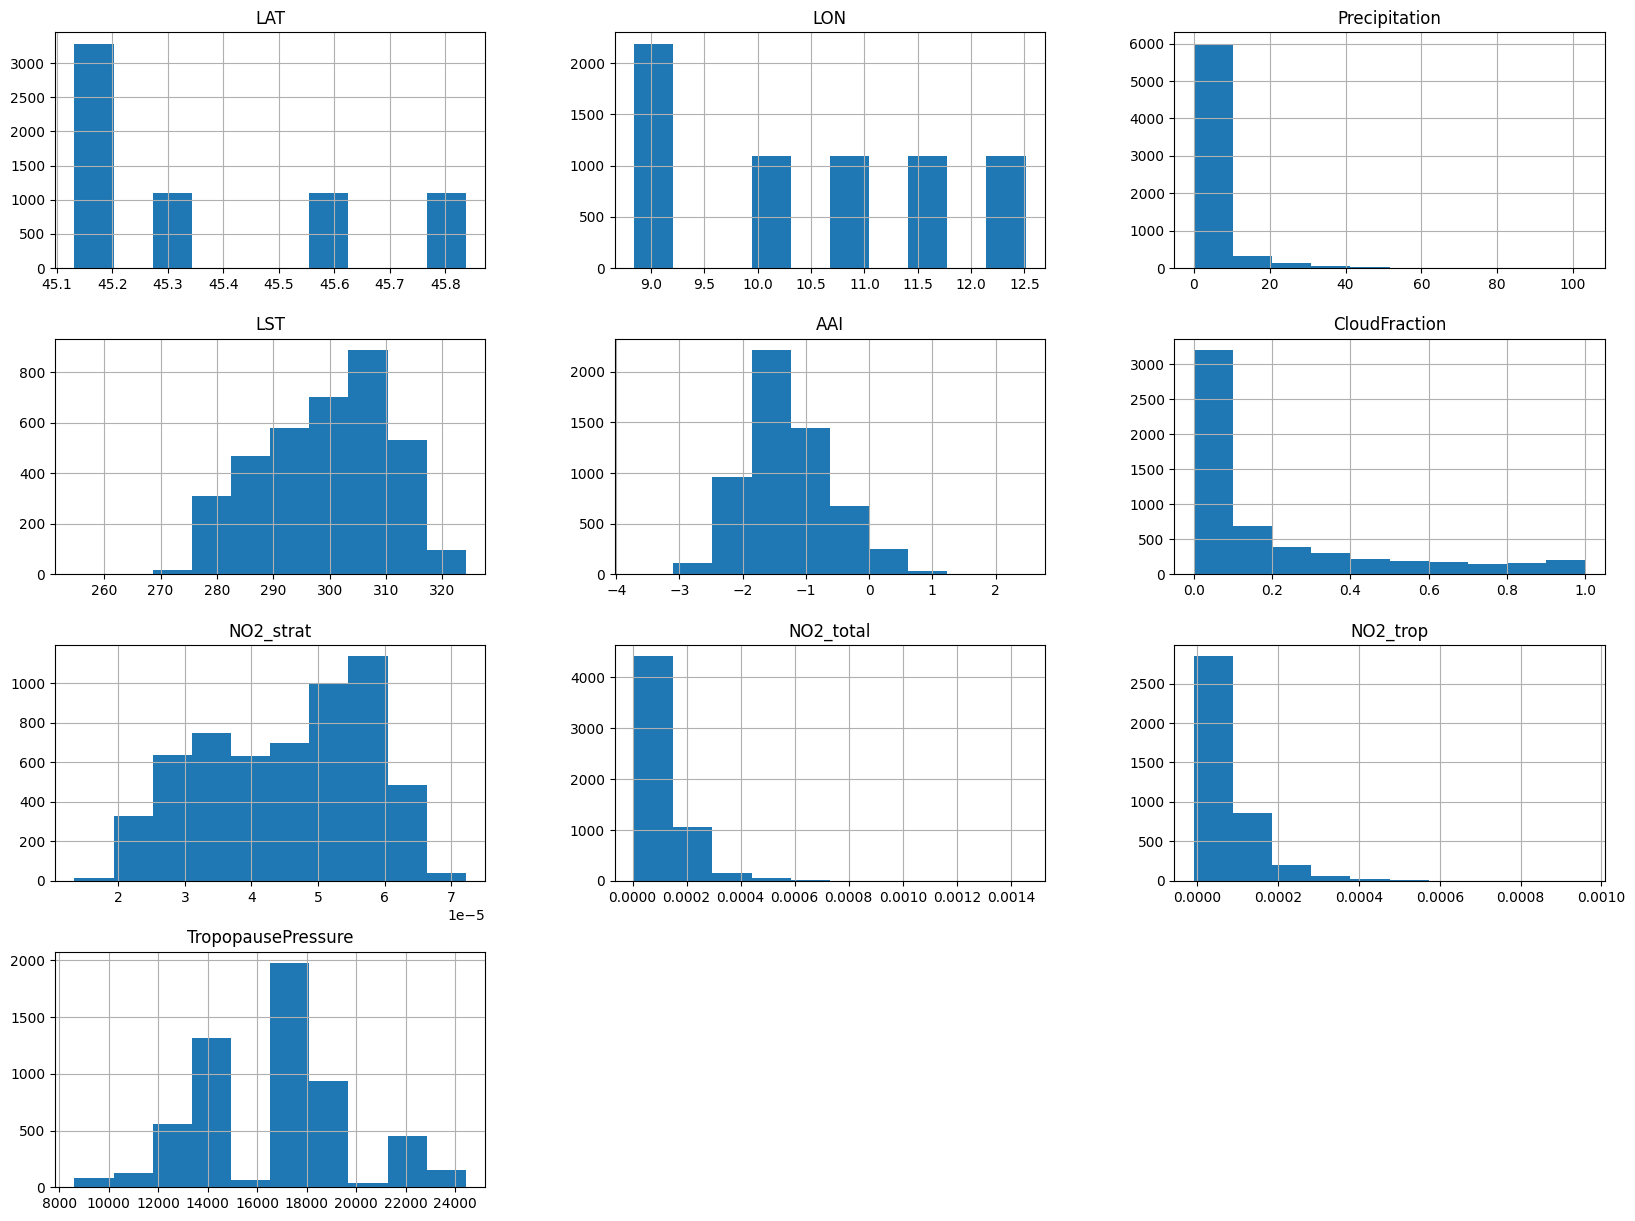

In [5]:
num_feats = list(test.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test[num_feats].hist(figsize=(20,15));

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


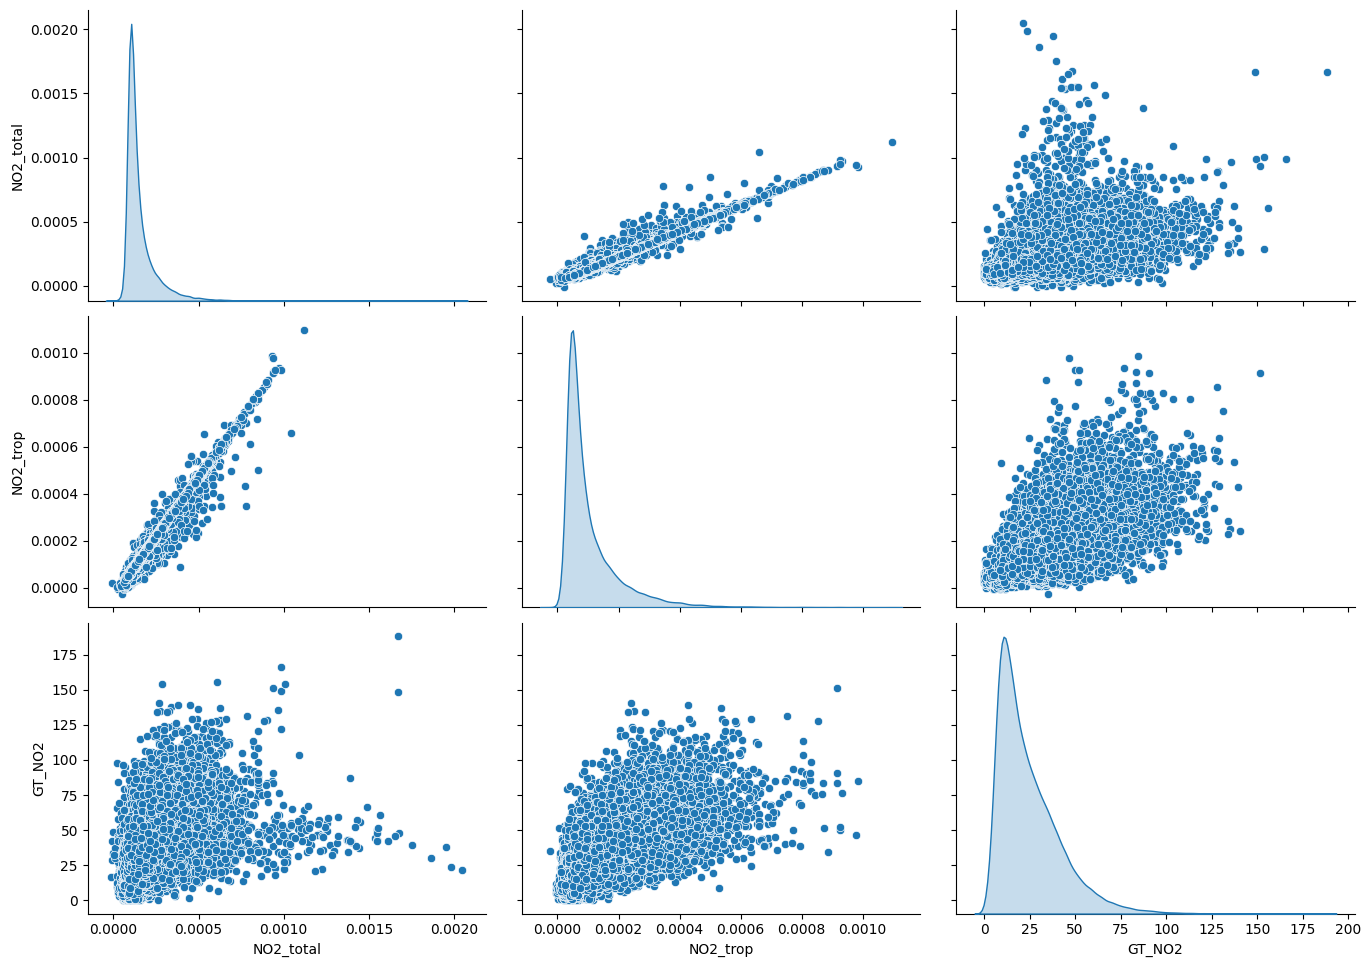

In [6]:
attributes = ["NO2_total", "NO2_trop","GT_NO2"]
sns.pairplot(train[attributes], diag_kind="kde")
plt.gcf().set_size_inches(15, 10)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

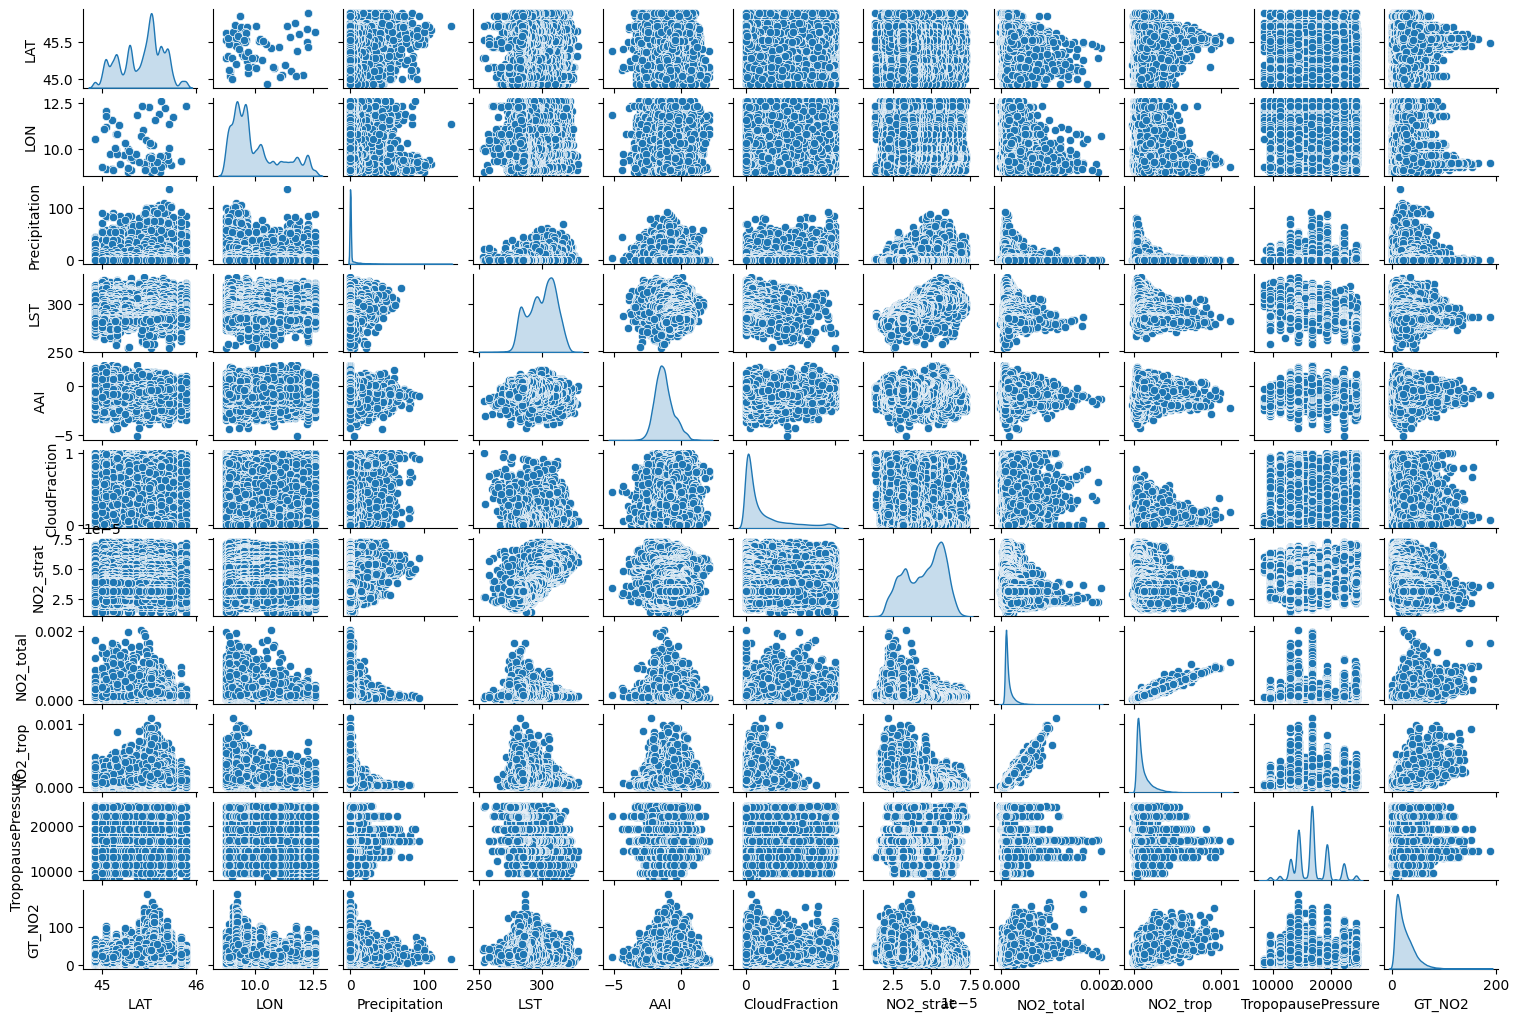

In [7]:
sns.pairplot(train, diag_kind="kde")
plt.gcf().set_size_inches(15, 10)

# Feature Engineering

In [8]:
train = train.sort_values('Date').reset_index(drop=True) 
test = test.sort_values('Date').reset_index(drop=True)

for df in (train,test):
    df['Date'] = pd.to_datetime(df['Date'])
    #df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
    #df['date_ofyear'] = df['Date'].dt.day_of_year
    df['DayOfWeek'] =  df['Date'].dt.dayofweek
    df['Day'] =  df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Month_start'] = df['Date'].dt.is_month_start
    df['Year'] =  df['Date'].dt.year
    df.set_index(df['Date'],inplace=True)
    df.drop(columns=['ID_Zindi','Date'],inplace=True)
    
def rolling_features(feature):
    for dataset in (train,test):
        dataset[f"{feature}_rolling_max_60"] = dataset[feature].rolling(60).max()

rolling_features('NO2_trop')
rolling_features('NO2_total')
rolling_features('TropopausePressure')
rolling_features('CloudFraction')
rolling_features('AAI')
rolling_features('LST')
rolling_features('Precipitation')

/tmp/ipykernel_18/3536013638.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/tmp/ipykernel_18/3536013638.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


# solve the collinearity 
When using supervised machine learning, it's important to inspect the correlation between the target and predictors/features. If you're using a time series approach, the model may be affected by collinearity (you are likely to use linear regression/Arima..), so inspect it. I used LGBMRegressor, which is tree-based and does not require removing collinear variables. 
you can start by removing all variables with(r > 0.9)


<Axes: >

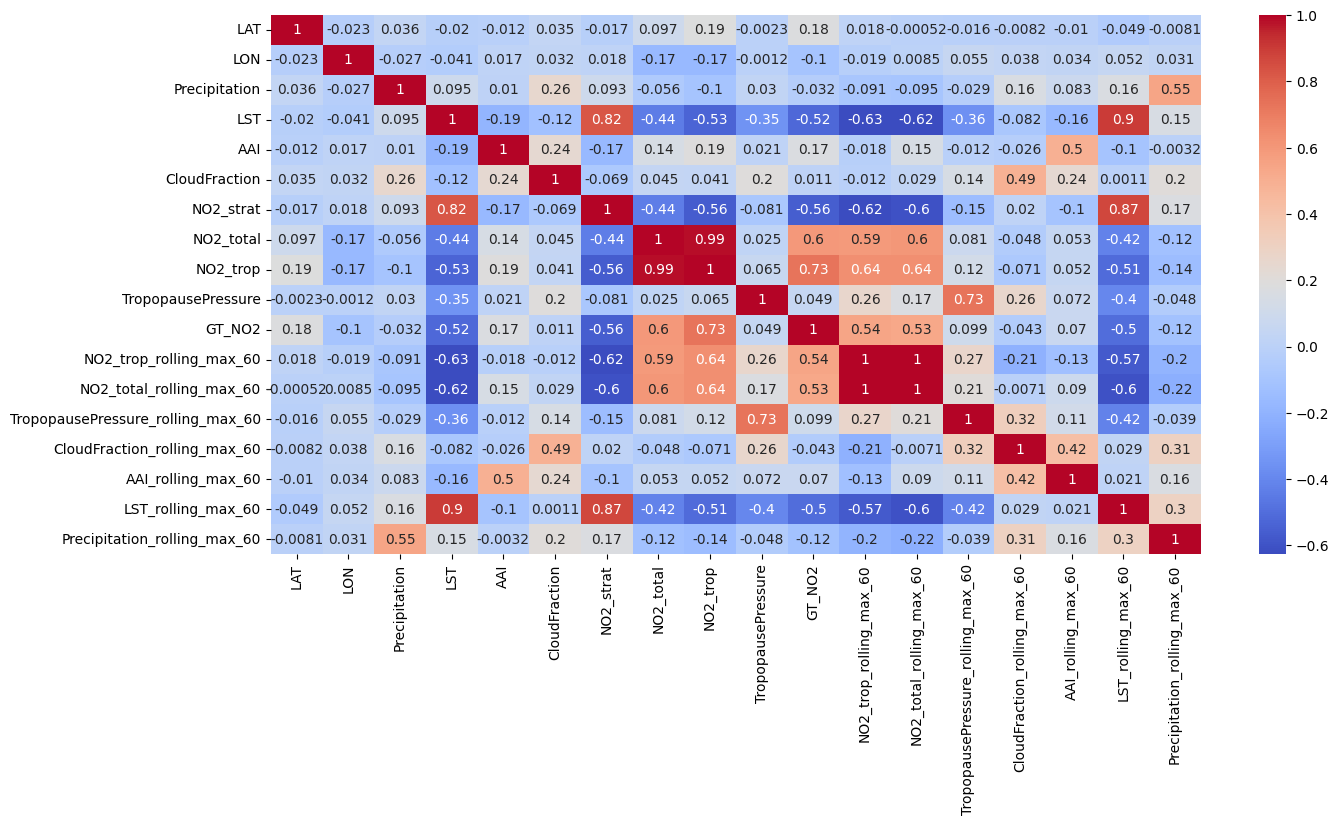

In [9]:
num_feats = train.select_dtypes(include='float')
corrs = num_feats.corr()
plt.figure(figsize=(15,7))
sns.heatmap(corrs, cmap='coolwarm', annot=True)

# time series Analysis
using the new 'train['Time']' time column mimicing the days of the years we will plot the target to see if there is any dependence on time

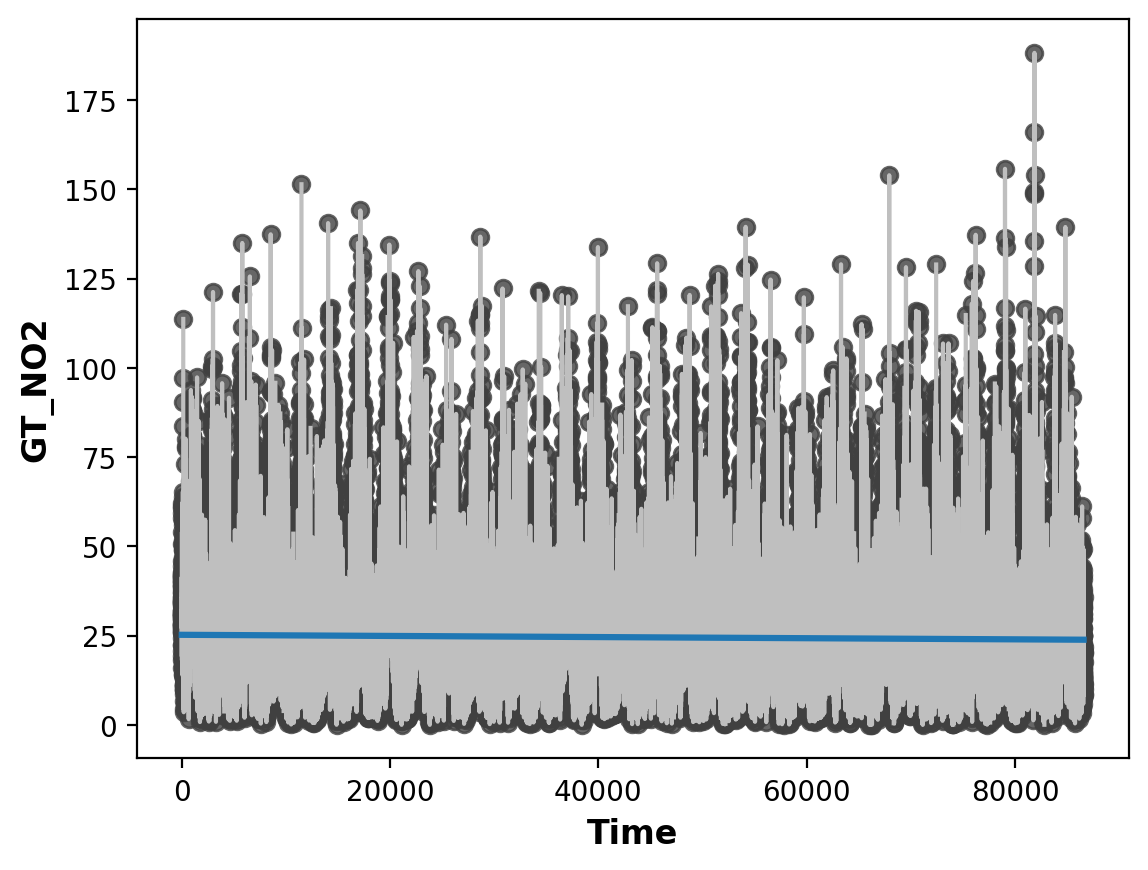

In [10]:
train['Time'] = np.arange(len(train.index))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots()
ax.plot('Time', 'GT_NO2', data=train, color='0.75')
ax = sns.regplot(x='Time', y='GT_NO2', data=train, ci=None, scatter_kws=dict(color='0.25'))

The target seems to be in chunks (higher in certain locations and may sound random) you can view this more accurately when you decompose the components as it is seasonal/stationary within the trend.

[]

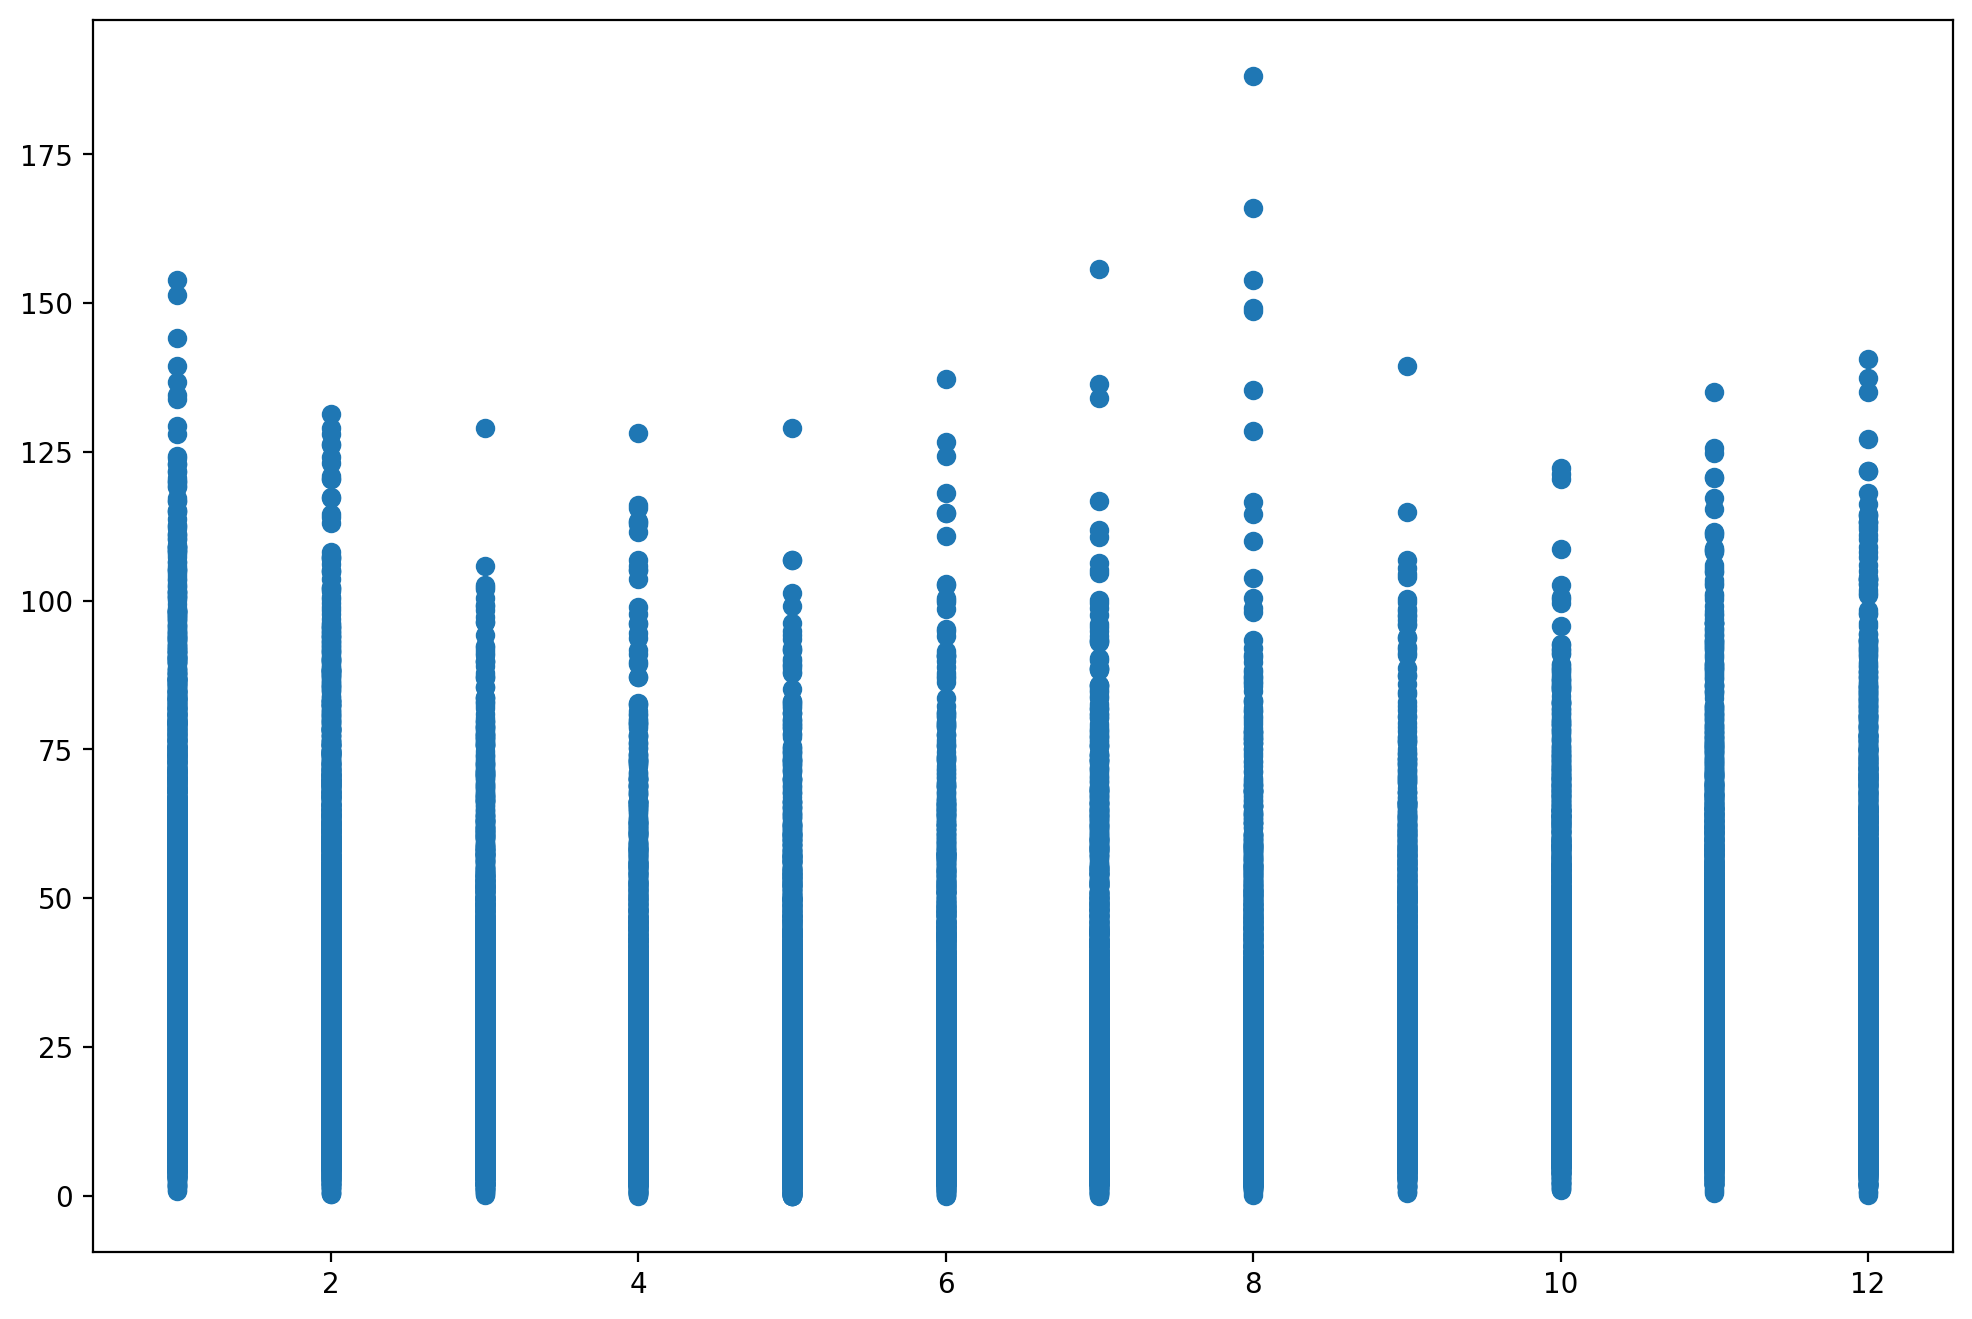

In [11]:
#NO2_Month
plt.figure(figsize=(12, 8))
plt.scatter(train["Month"],train["GT_NO2"])
plt.plot()

Higher NO2 levels correlate with January, August, and December
you can plot the day of the week or any time related feature to see if there is time dependence

We will split the data into two sets: train (all data points observed before 05-01-2021) and validation (all data points observed after 05-02-2021). 

Keep in mind that most time series practitioners recommend two cycles of training (e.g., two years), especially if you want to catch the trend.

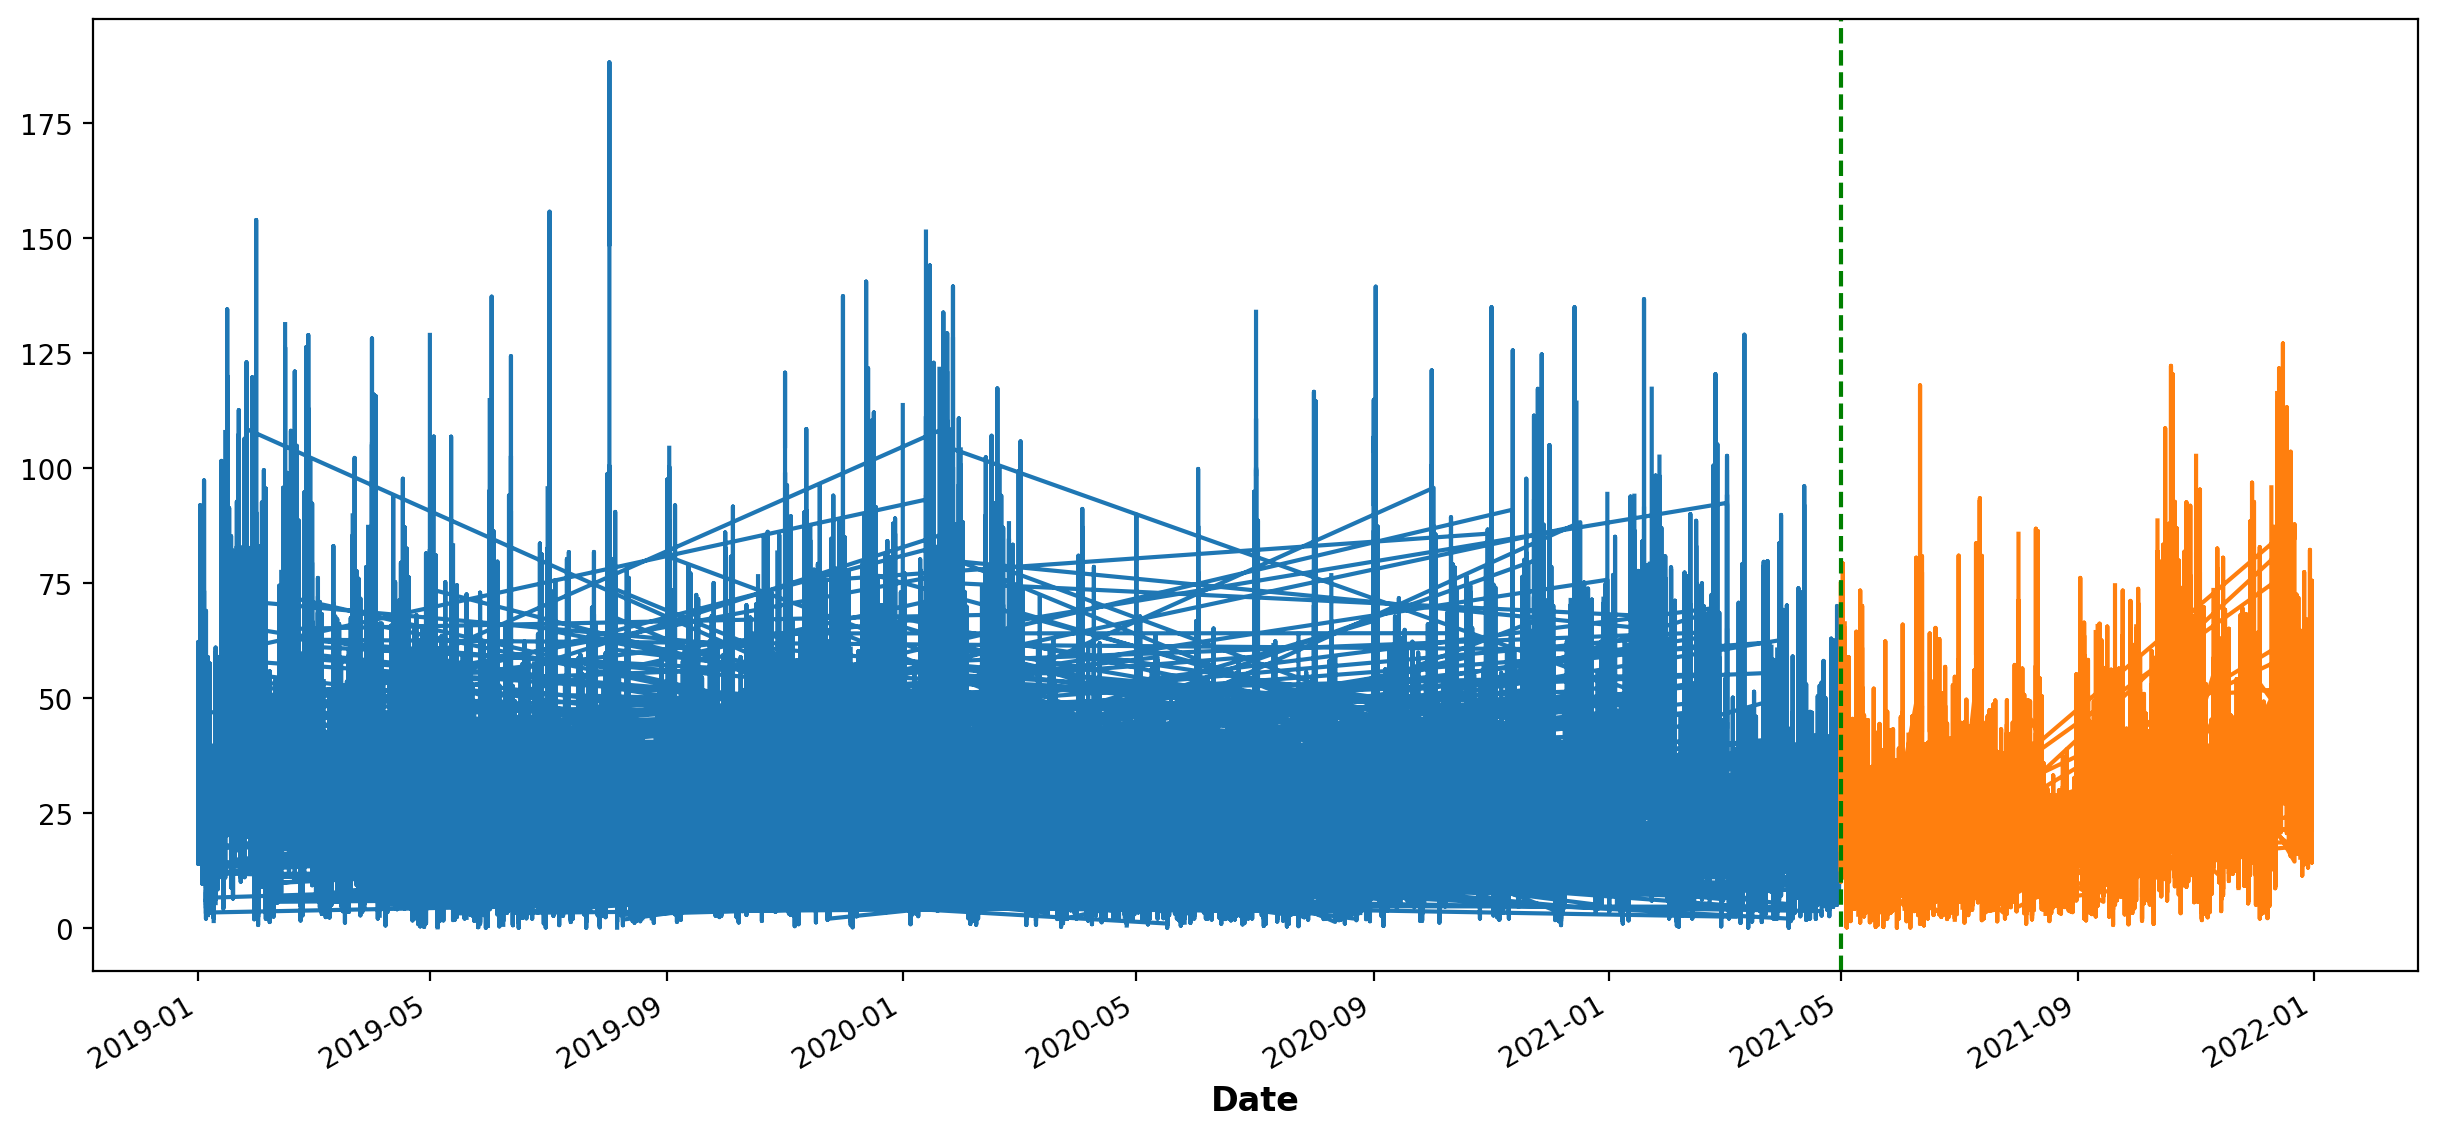

In [12]:
trainset = train.loc[train.index < '05-01-2021']
validation  =  train.loc[train.index >= '05-01-2021']
fig , ax = plt.subplots(figsize=(15,7))
trainset['GT_NO2'].plot(ax=ax, label='training_set')
validation['GT_NO2'].plot(ax=ax, label='Test_set')
ax.axvline('05-01-2021', color='green',ls='--')
plt.show()

The Orange Color For validation 


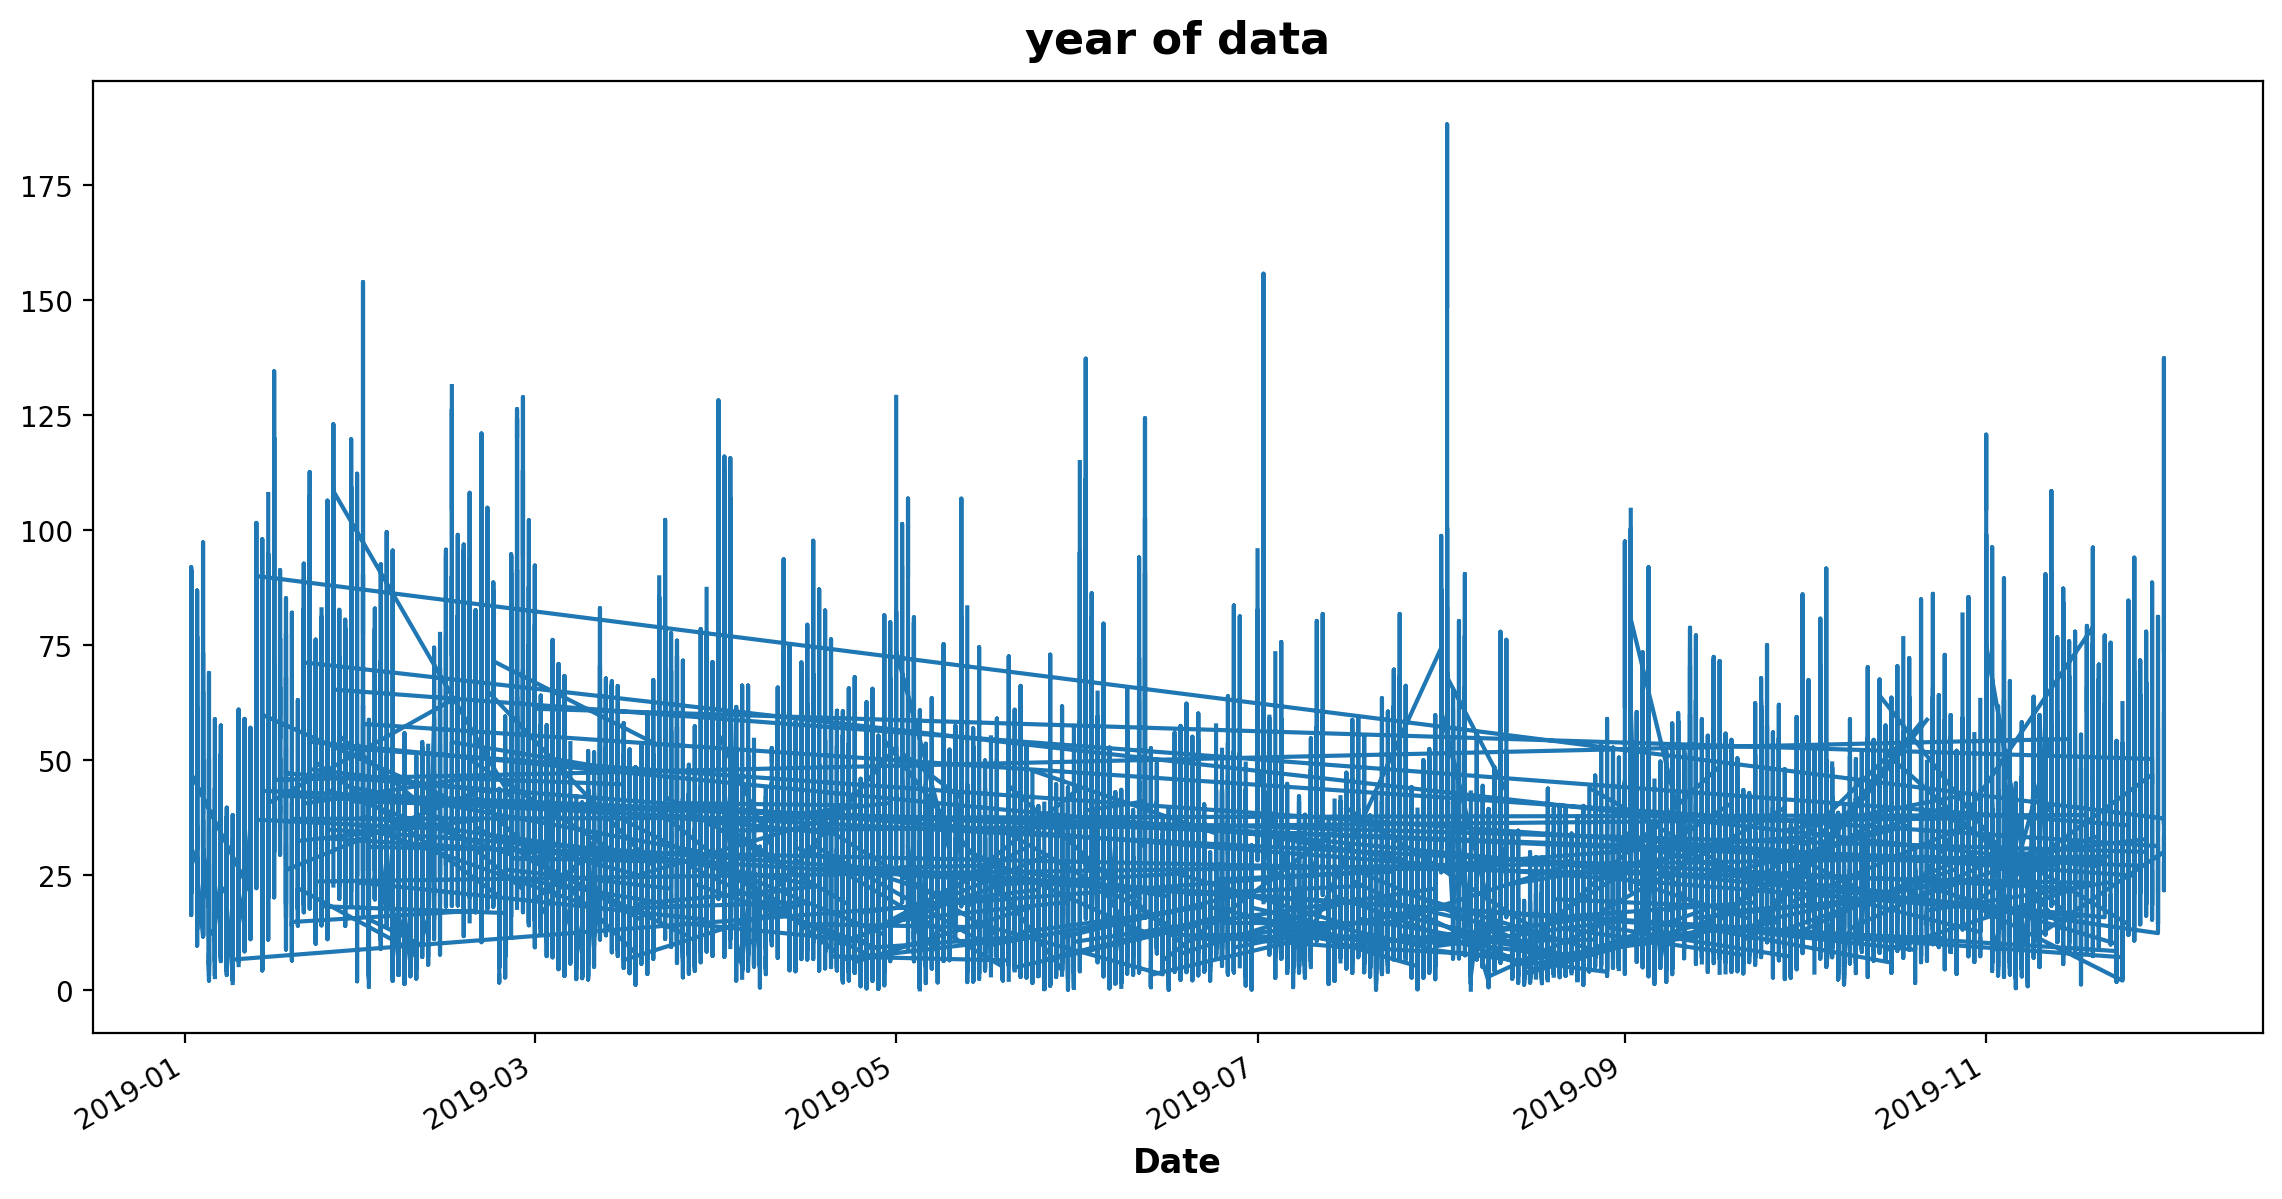

In [13]:
train['GT_NO2'].loc[((train.index > '01-01-2019') & (train.index <='12-01-2019'))].plot(figsize=(14,7), title='year of data')
plt.show()

Auto-correlation allows us to determine whether there is a relationship between the current value of a time and its previous values, and we are looking at a lag of 30. The action must show a trend (e.g., every 5 days in day auto-correlation grows or drops). Alternatively, you may use a latency of 6 as a predictor/feature. 


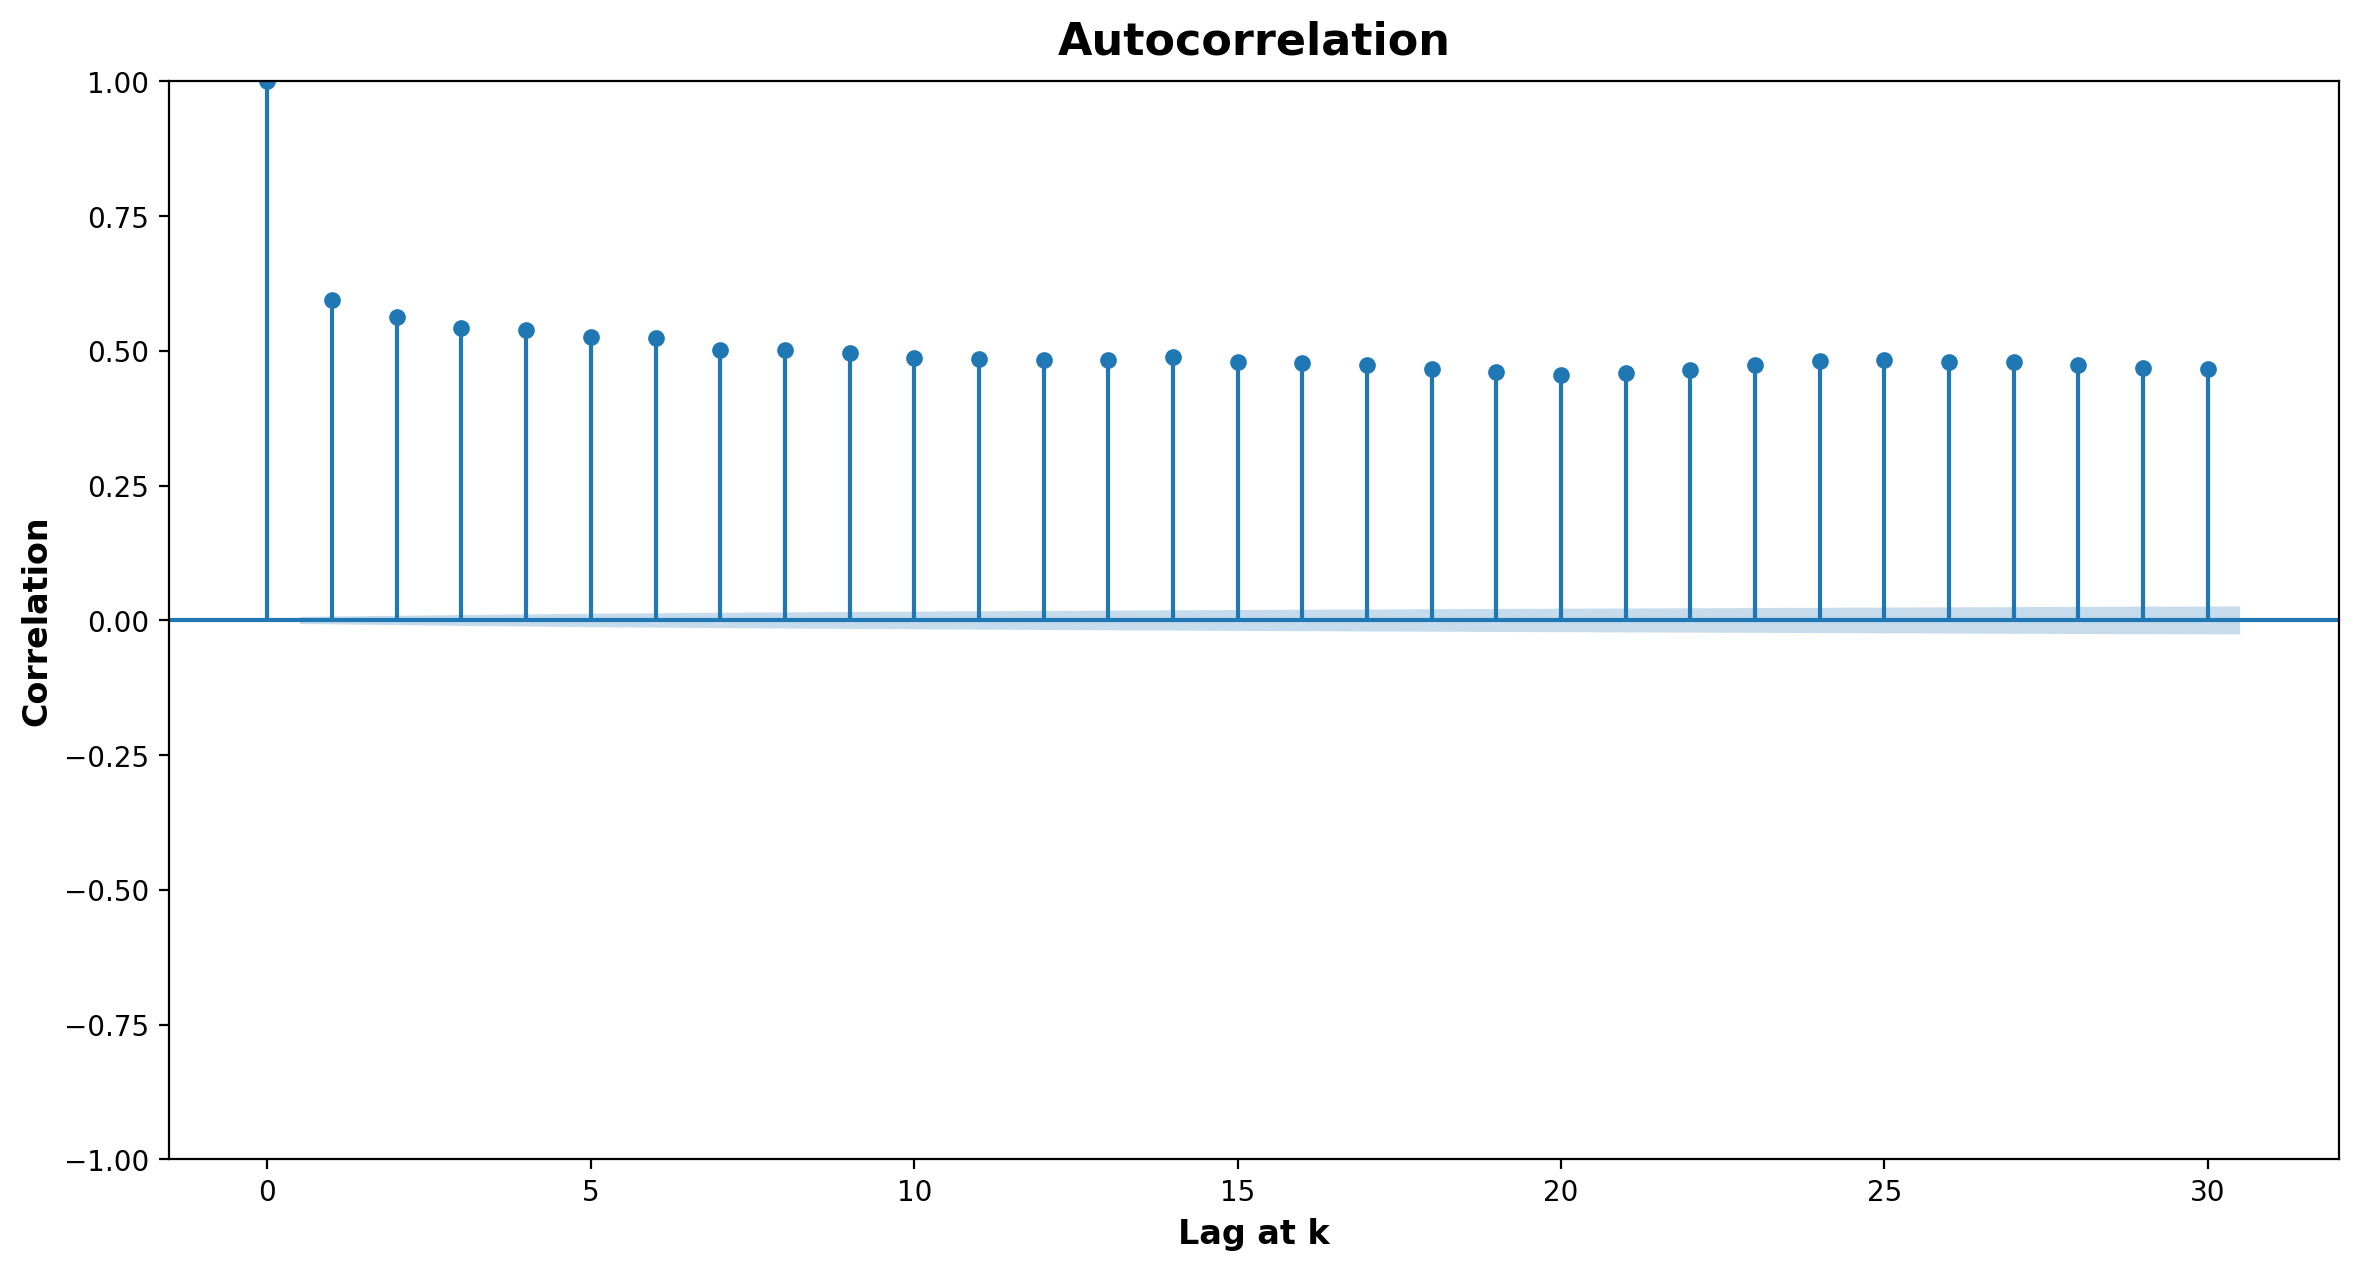

In [14]:
rcParams["figure.figsize"] = 14, 7
fig = plot_acf(train["GT_NO2"].ffill(), lags=30)
plt.title("Autocorrelation")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
plt.show()

# What is Time Series Decomposition?

![image](https://codefinity-content-media.s3.eu-west-1.amazonaws.com/Time+series_Images/images_2/image8.png)

as we know the observations measured over time can be decomposed into 2 main componenets
## time series = signal(trend/seasonality) + noise 
the addivtive version of the decomposision is = 
## Y = Tt + St + Et 
where 
- Tt = is the trend 
- St = Seasonality 
- Et = Error 

there is sometime a cyclic term added but it's uncommon to be included
if you didn't understand this it will make sense after apply the decompose from statsmodels library

/tmp/ipykernel_18/3944936905.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='1/1/2019', end='1/1/2022', freq='M')


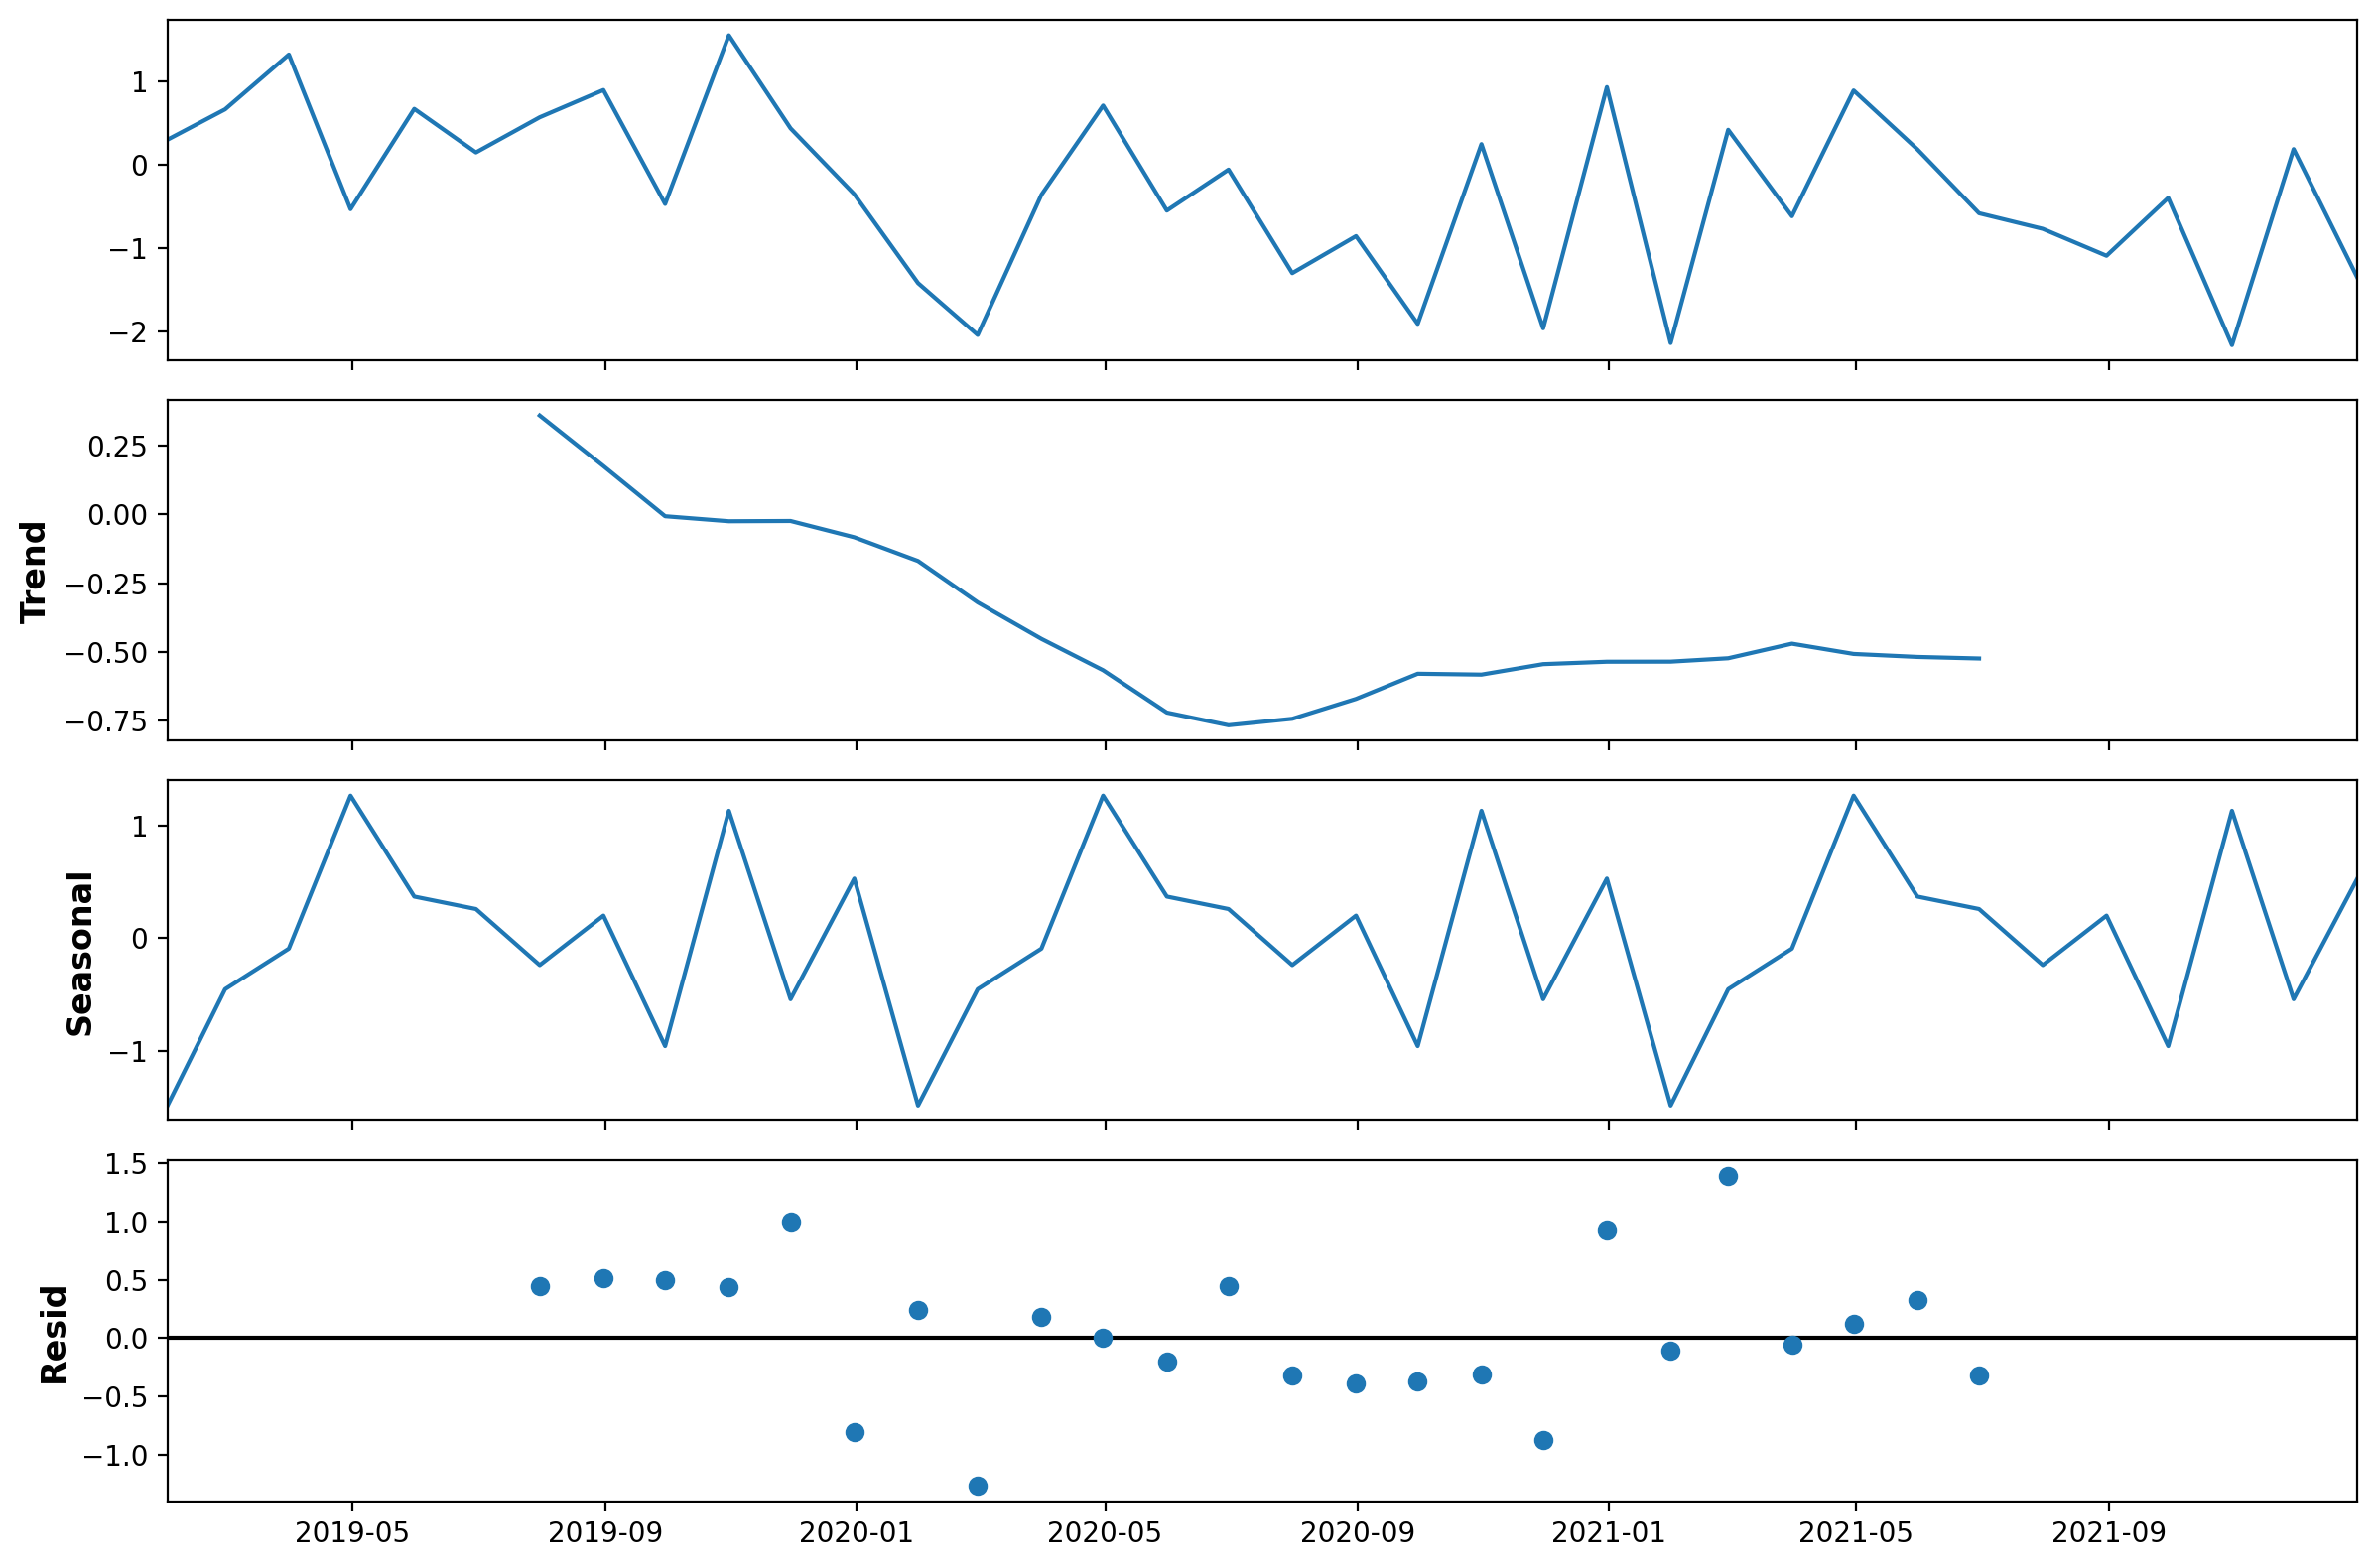

In [15]:
date_rng = pd.date_range(start='1/1/2019', end='1/1/2022', freq='M')
bio = pd.Series(np.random.randn(len(date_rng)), index=date_rng)
bio = pd.Series(bio, index=date_rng)
CFG = {'img_dim1': 12, 'img_dim2': 8}
plt.rcParams.update({'figure.figsize': (CFG['img_dim1'], CFG['img_dim2'])})
decomposition = seasonal_decompose(bio, period=12)
figure = decomposition.plot()
plt.show()

now when we come up with the target and separate the trend from the seasonal component, we can see that the seasonal component (think of it as the change that occurs throughout the year) is certainly time dependent. The third figure depicts the results when we separate them from the original plot of the target/time.

# Encoding

In [16]:
train.drop(columns='Time', axis=1,inplace=True)

In [17]:
le = LabelEncoder()
for df in(train,test): 
    for col in df.columns: 
        if df[col].dtype == 'object': 
            df[col] = le.fit_transform(df[col])

#dropping 

# Validation 

In [18]:
groups = train['ID']
model =  LGBMRegressor(random_state=7)
n_splits = 5
n = train['GT_NO2'].count()
#num_bins = int(1 + np.log2(n))
#train['GT_NO2_bins'] = pd.cut(train['GT_NO2'], bins=num_bins, labels=False)
#test['GT_NO2_bins'] = pd.cut(test['GT_NO2'], bins=num_bins, labels=False)

In [19]:
model = LGBMRegressor(random_state=7)
n_splits = 4
cv = GroupKFold(n_splits=n_splits)

def validate(trainset, testset, target_col):
    model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    print('std:', valid_testset.std())
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    print('score:', score)

    return score
stds = []
rmse = []

for train_idx, test_idx in cv.split(train.drop(columns='GT_NO2'), train['GT_NO2'], groups=groups):
    train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
    stds.append(test_v['GT_NO2'].std())
    rmse.append(validate(train_v, test_v, 'GT_NO2'))

print('RMSE:', np.array(rmse).mean())
print('RMSE std:', np.array(rmse).std())
print('Standard Deviations:', stds)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4017
[LightGBM] [Info] Number of data points in the train set: 64664, number of used features: 23
[LightGBM] [Info] Start training from score 23.081821
std: 15.816996333580377
score: 11.844766898781149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4023
[LightGBM] [Info] Number of data points in the train set: 64664, number of used features: 23
[LightGBM] [Info] Start training from score 22.740670
std: 17.917665740671513
score: 13.322993463801057
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4014
[LightGBM] [Info] 

In [20]:
train.columns

Index(['ID', 'LAT', 'LON', 'Precipitation', 'LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure', 'GT_NO2',
       'DayOfWeek', 'Day', 'Month', 'Month_start', 'Year',
       'NO2_trop_rolling_max_60', 'NO2_total_rolling_max_60',
       'TropopausePressure_rolling_max_60', 'CloudFraction_rolling_max_60',
       'AAI_rolling_max_60', 'LST_rolling_max_60',
       'Precipitation_rolling_max_60'],
      dtype='object')

In [21]:
test.columns

Index(['ID', 'LAT', 'LON', 'Precipitation', 'LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure', 'DayOfWeek',
       'Day', 'Month', 'Month_start', 'Year', 'NO2_trop_rolling_max_60',
       'NO2_total_rolling_max_60', 'TropopausePressure_rolling_max_60',
       'CloudFraction_rolling_max_60', 'AAI_rolling_max_60',
       'LST_rolling_max_60', 'Precipitation_rolling_max_60'],
      dtype='object')

In [22]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y_pred = model.predict(test)
sub_df = pd.DataFrame({'id': test_id,'GT_NO2':y_pred})
sub_df.to_csv('submission.csv', index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4075
[LightGBM] [Info] Number of data points in the train set: 86584, number of used features: 23
[LightGBM] [Info] Start training from score 23.250548


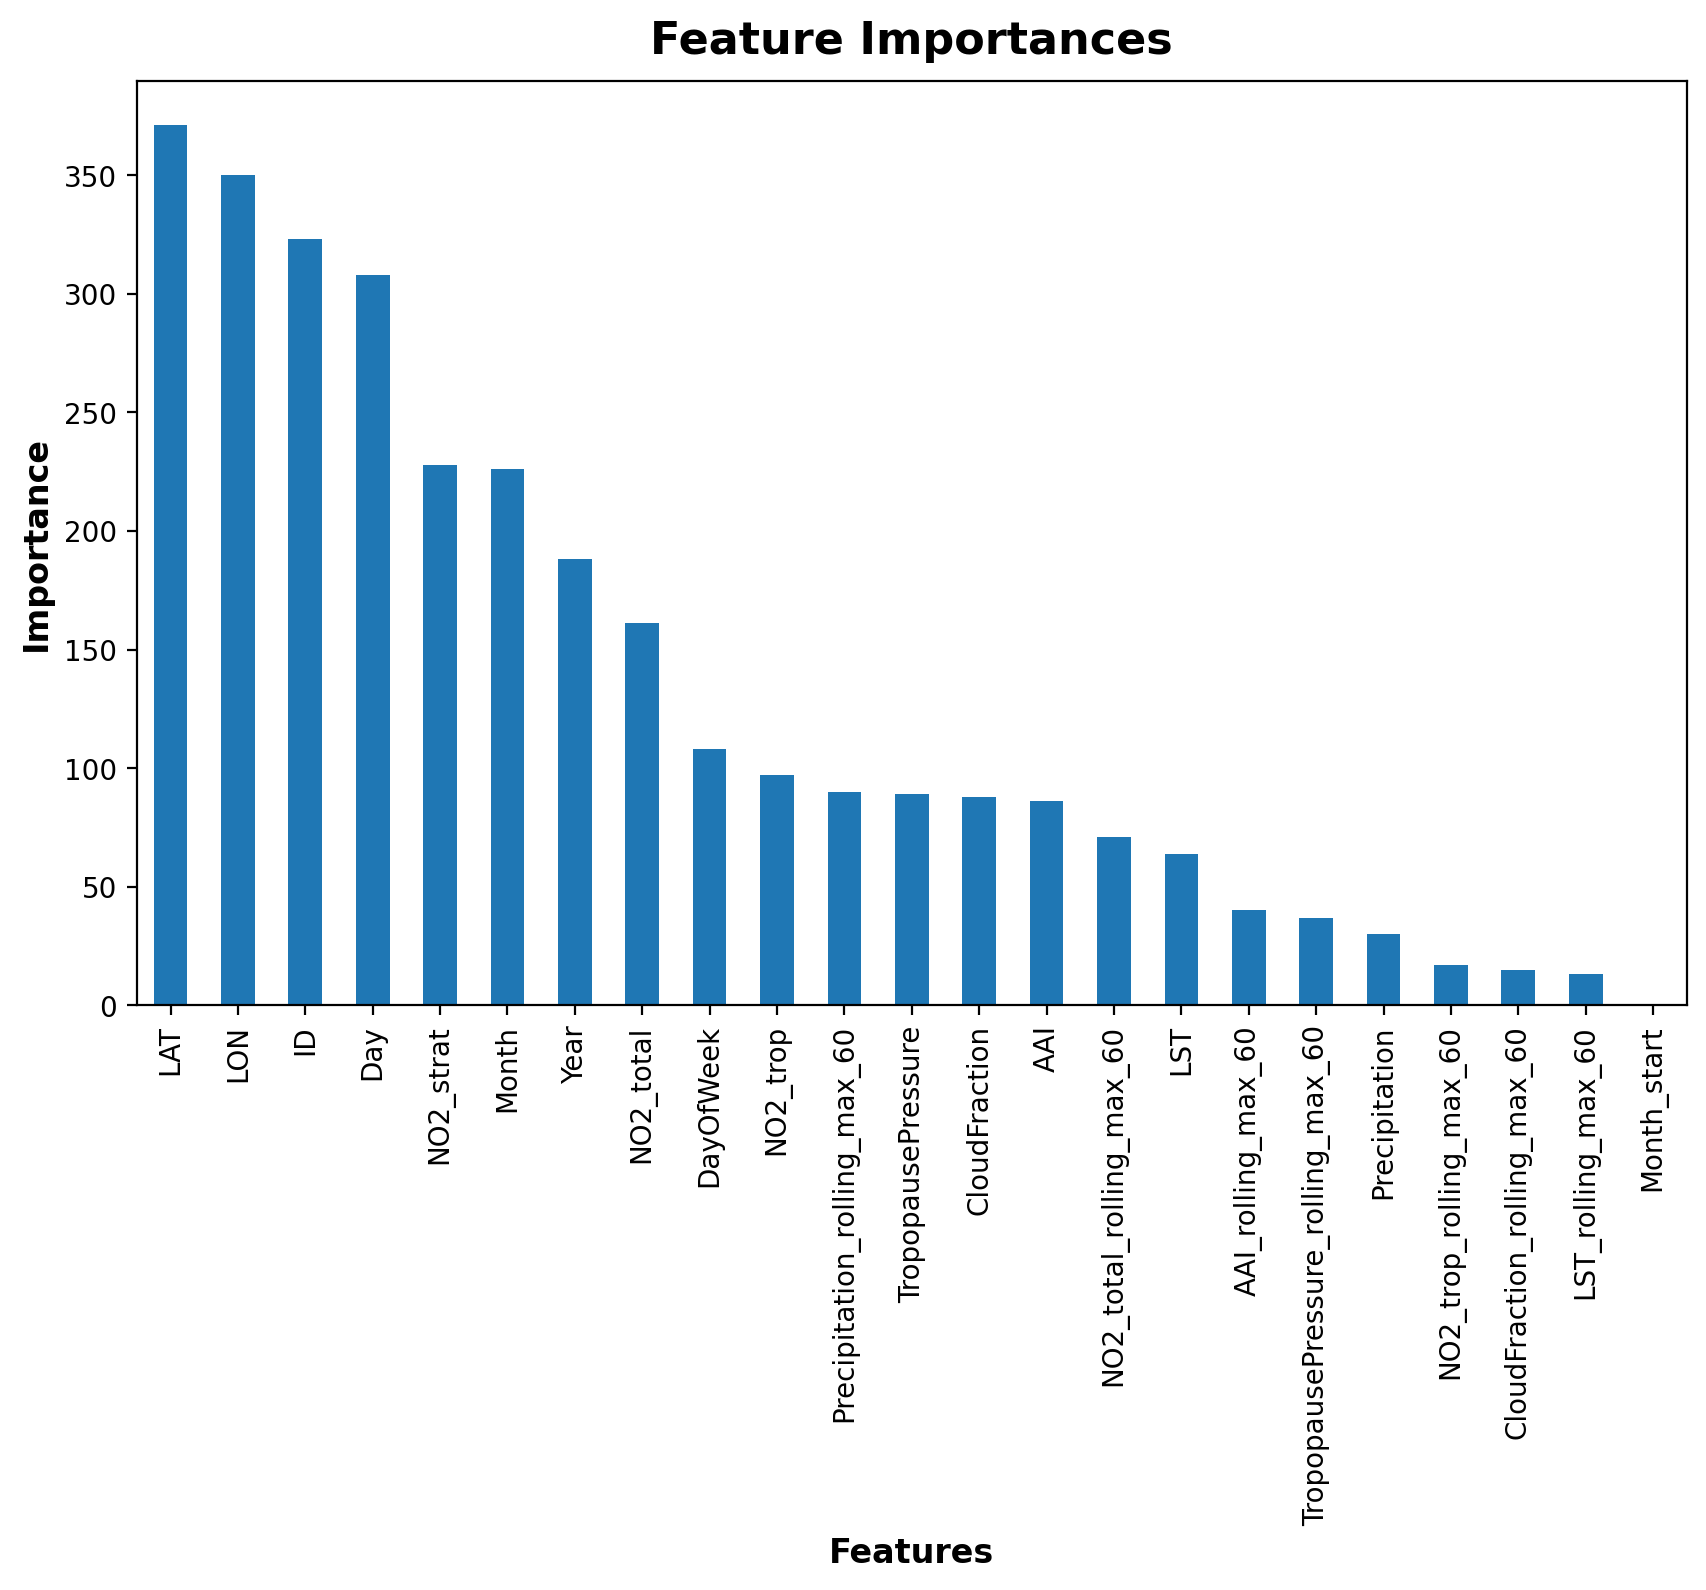

In [23]:
importances = model.feature_importances_
names = model.feature_name_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)

fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(10, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


## what's Next 
Well, this was one of the baselines I created to test the assumption of time dependence. Perhaps using the seasonality features will come up wtih better results or not! Maybe you found it out - everything is experimental; best of luck :). 

Please - we all make mistakes, and I'm no exception; in order to make this notebook as useful as possible, please contact me with any suggestions for revisions. 
